In [53]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import time
import math
import experiments.toy_regression as exp
import matplotlib.pyplot as plt
from training.regresssion import RegressionResults, plot_calibration, plot_table
from training.util import plot_losses

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
device = torch.device("cpu")

In [21]:
batch_size = 50
noise = torch.tensor(0.02).to(device) # 3, 0.02
def make_layers(in_size):
    return [
        ("fc", (in_size, 100)),
        ("relu", ()),
        ("fc", (100, 1))
    ]
learn_var = False
def sgd(lr):
    return lambda parameters: torch.optim.SGD(parameters, lr)

In [22]:
from experiments.uci import UCIDatasets
torch.manual_seed(42)
uci = UCIDatasets("housing", "./data/")
trainloader = torch.utils.data.DataLoader(uci.get_split(train=True), batch_size)
testloader = torch.utils.data.DataLoader(uci.get_split(train=False), batch_size)

In [100]:
torch.manual_seed(42)
from training.pp import PointPredictor
pp = PointPredictor(make_layers(13))
pp.train(2000, torch.nn.MSELoss(), sgd(lr=0.01), trainloader, batch_size, device, report_every_epochs=100)
pp_res = RegressionResults(testloader, "Point Predictor", pp.infer, 1, torch.tensor(0.1), device, fit_gaussian=False)

Generated model: Sequential(
  (0): Linear(in_features=13, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)
1501 trainable parameters
Epoch 0: loss 0.013248498551547527
Epoch 100: loss 0.002138290088623762
Epoch 200: loss 0.0016387313371524215
Epoch 300: loss 0.0013772201491519809
Epoch 400: loss 0.001213807612657547
Epoch 500: loss 0.0010988737922161818
Epoch 600: loss 0.0010097557678818703
Epoch 700: loss 0.0009362094569951296
Epoch 800: loss 0.0008757570758461952
Epoch 900: loss 0.0008272558334283531
Epoch 1000: loss 0.0007847875822335482
Epoch 1100: loss 0.0007469563861377537
Epoch 1200: loss 0.00071212078910321
Epoch 1300: loss 0.0006812236970290542
Epoch 1400: loss 0.0006535446154884994
Epoch 1500: loss 0.0006287970463745296
Epoch 1600: loss 0.0006055066478438675
Epoch 1700: loss 0.00058410142082721
Epoch 1800: loss 0.0005639703013002872
Epoch 1900: loss 0.0005449713207781315
Final loss 0.0005274211871437728


In [108]:
from training.swag import SwagModel
torch.manual_seed(42)

swag_config = {
    "start_epoch": 1500,
    "update_every_batches": len(trainloader) * 4,
    "deviation_samples": 50
}
swag = SwagModel(make_layers(13), swag_config)
swag.train(2000, torch.nn.MSELoss(), sgd(lr=0.01), trainloader, batch_size, device, report_every_epochs=100)
swag_res = RegressionResults(testloader, "SWAG", swag.infer, 100, torch.tensor(0.1), device, fit_gaussian=False)

Generated model: Sequential(
  (0): Linear(in_features=13, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)
1501 trainable parameters
Epoch 0: loss 0.013248498551547527
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 100: loss 0.002138290088623762
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 200: loss 0.0016387313371524215
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 300: loss 0.0013772201491519809
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 400: loss 0.001213807612657547
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 500: loss 0.0010988737922161818
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 600: loss 0.0010097557678818703
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 700: loss 0.0009362094569951296
SWAG: Collected 0 out o

In [102]:
from training.ensemble import Ensemble

torch.manual_seed(42)
ensemble = Ensemble([PointPredictor(make_layers(13)) for _ in range(5)])
ensemble.train(2000, torch.nn.MSELoss(), sgd(0.01), trainloader, batch_size, device, report_every_epochs=100)
ensemble_res = RegressionResults(testloader, "Ensemble-5", ensemble.infer, 1, torch.tensor(0.1), device, fit_gaussian=False)

Generated model: Sequential(
  (0): Linear(in_features=13, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)
1501 trainable parameters
Generated model: Sequential(
  (0): Linear(in_features=13, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)
1501 trainable parameters
Generated model: Sequential(
  (0): Linear(in_features=13, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)
1501 trainable parameters
Generated model: Sequential(
  (0): Linear(in_features=13, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)
1501 trainable parameters
Generated model: Sequential(
  (0): Linear(in_features=13, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)
1501 trainable parameters
Training ensemble member 0
Epoch 0: loss 0.01324849855154752

In [103]:
from training.dropout import MonteCarloDropoutModule

torch.manual_seed(42)
mc_dropout = MonteCarloDropoutModule(make_layers(13), 0.1)
mc_dropout.train(2000, torch.nn.MSELoss(), sgd(0.01), trainloader, batch_size, device, report_every_epochs=100)
mc_res = RegressionResults(testloader, "Monte Carlo Dropout", mc_dropout.infer, 100, torch.tensor(0.1), device, fit_gaussian=False)

Generated model: Sequential(
  (0): Linear(in_features=13, out_features=100, bias=True)
  (1): FixableDropout()
  (2): ReLU()
  (3): Linear(in_features=100, out_features=1, bias=True)
)
1501 trainable parameters
Epoch 0: loss 0.014117834158241749
Epoch 100: loss 0.0028007100336253643
Epoch 200: loss 0.0021105739288032055
Epoch 300: loss 0.0018991016549989581
Epoch 400: loss 0.0020243043545633554
Epoch 500: loss 0.0016163496766239405
Epoch 600: loss 0.0016585075063630939
Epoch 700: loss 0.001472656731493771
Epoch 800: loss 0.0013975793262943625
Epoch 900: loss 0.0014135426608845592
Epoch 1000: loss 0.0015130003448575735
Epoch 1100: loss 0.0013220935361459851
Epoch 1200: loss 0.0012544571654871106
Epoch 1300: loss 0.0013381822500377893
Epoch 1400: loss 0.0012439090060070157
Epoch 1500: loss 0.0013575819320976734
Epoch 1600: loss 0.0011522340355440974
Epoch 1700: loss 0.001121309120208025
Epoch 1800: loss 0.0012288815341889858
Epoch 1900: loss 0.0010705700842663646
Final loss 0.0010894988

In [104]:
from training.bbb import GaussianPrior, BBBModel

torch.manual_seed(42)
bbb_prior = GaussianPrior(0, 1)
bbb = BBBModel(bbb_prior, "activations", make_layers(13))
bbb.train(2000, torch.nn.MSELoss(reduction="sum"), sgd(lr=0.01), trainloader, batch_size, device, report_every_epochs=100, kl_rescaling=5)
bbb_res = RegressionResults(testloader, "Bayes By Backprop", bbb.infer, 100, torch.tensor(0.1), device, fit_gaussian=False)

Generated model: Sequential(
  (0): BBBLinear()
  (1): ReLU()
  (2): BBBLinear()
)
3002 trainable parameters
Epoch 0: loss 38.47932815551758
Epoch 100: loss 18.209753036499023
Epoch 200: loss 10.601652145385742
Epoch 300: loss 7.9056315422058105
Epoch 400: loss 6.61157751083374
Epoch 500: loss 5.8923258781433105
Epoch 600: loss 5.432576656341553
Epoch 700: loss 5.219537258148193
Epoch 800: loss 5.05268669128418
Epoch 900: loss 4.863807678222656
Epoch 1000: loss 4.650913238525391
Epoch 1100: loss 4.8538665771484375
Epoch 1200: loss 4.572977066040039
Epoch 1300: loss 4.609631538391113
Epoch 1400: loss 4.570050239562988
Epoch 1500: loss 4.526856899261475
Epoch 1600: loss 4.5622711181640625
Epoch 1700: loss 4.504047870635986
Epoch 1800: loss 4.424902439117432
Epoch 1900: loss 4.500304698944092
Final loss 4.455639362335205


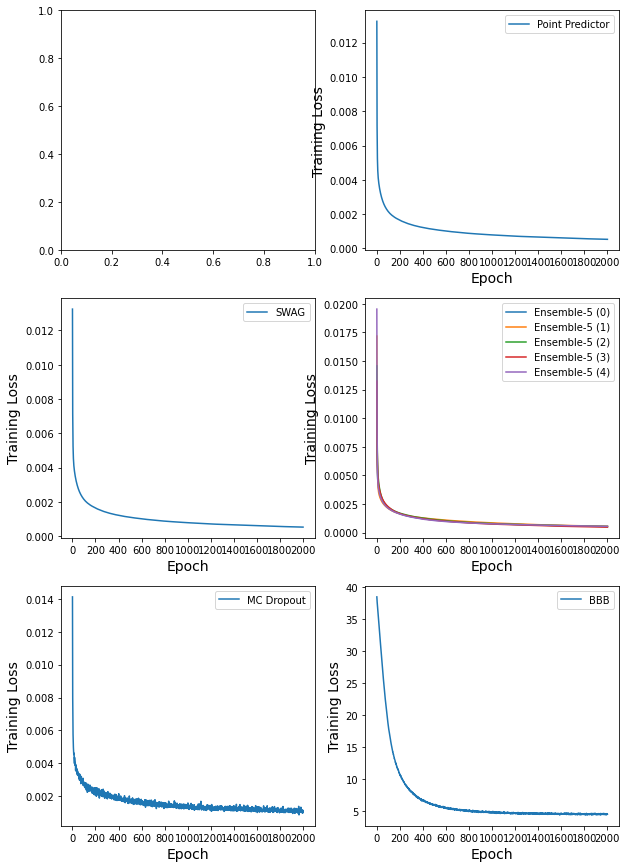

In [109]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
plot_losses("Point Predictor", pp.all_losses(), axes[0,1])
plot_losses("SWAG", swag.all_losses(), axes[1,0])
plot_losses("Ensemble-5", ensemble.all_losses(), axes[1,1])
plot_losses("MC Dropout", mc_dropout.all_losses(), axes[2,0])
plot_losses("BBB", bbb.all_losses(), axes[2,1])

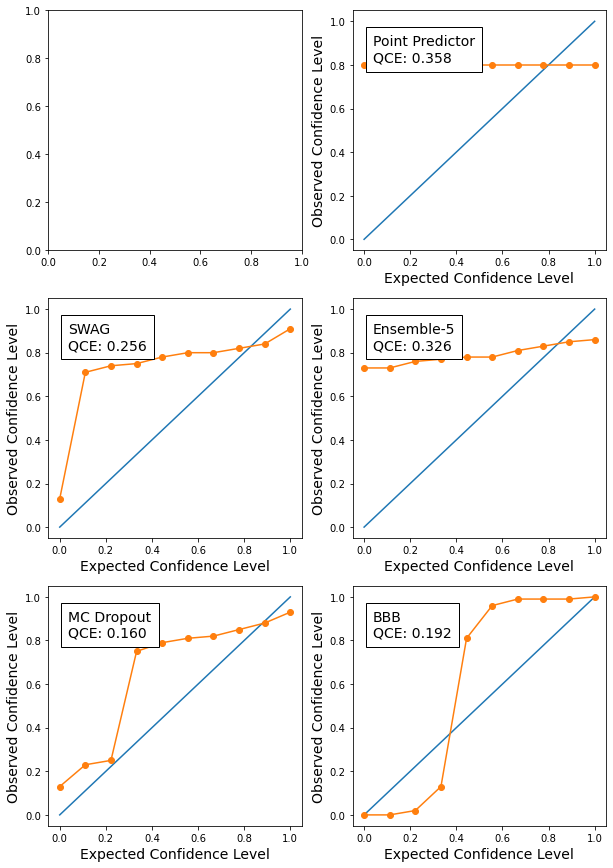

In [110]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
plot_calibration("Point Predictor", pp_res, axes[0,1])
plot_calibration("SWAG", swag_res, axes[1,0])
plot_calibration("Ensemble-5", ensemble_res, axes[1,1])
plot_calibration("MC Dropout", mc_res, axes[2,0])
plot_calibration("BBB", bbb_res, axes[2,1])

In [111]:
plot_table([pp_res, swag_res, ensemble_res, mc_res, bbb_res])

| Method              |     LML |   Mean MSE |   MSE of Means |   QCE |
|---------------------+---------+------------+----------------+-------|
| Point Predictor     | -28.504 |      0.158 |          0.158 | 0.358 |
| SWAG                | -28.039 |      0.002 |          0.156 | 0.256 |
| Ensemble-5          | -23.821 |      0.03  |          0.14  | 0.326 |
| Monte Carlo Dropout | -20.777 |      0.001 |          0.128 | 0.16  |
| Bayes By Backprop   | -41.038 |      0.021 |          0.207 | 0.192 |
